In [52]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint 

# Data Preparation
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
# from sklearn.cluster import KMeans
# from sklearn.ensemble import RandomForestClassifier

# Evalution Model
from sklearn.metrics import (roc_curve, roc_auc_score, 
                            ConfusionMatrixDisplay, confusion_matrix)

#        Data Understanding

In [2]:
root_train = os.path.abspath(r'Data\train.csv')
root_test = os.path.abspath(r'Data\test.csv')
data_train = pd.read_csv(root_train)
data_test = pd.read_csv(root_test)

        Inicialmente foi realizado uma descrição sucinta dos dados para identificar problemas mais genéricos como dados faltantes e dados em formato errado. 

In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 1001 entries, var1 to alvo
dtypes: float64(999), int64(2)
memory usage: 305.5 MB


In [79]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 1001 entries, var1 to alvo
dtypes: float64(999), int64(2)
memory usage: 76.4 MB


In [4]:
data_train.shape

(40000, 1001)

In [19]:
data_train['alvo'].describe()

count    40000.000000
mean         0.135875
std          0.342660
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: alvo, dtype: float64

        Uma análise visual da distruição dos dados foi realizada para identificar a distribuição em que eles se encontram. Como trata-se de dados sem um formato gaussiano, pode-se concluir que uma padronização dos dados não pode ser realizada com padrões de dados 'uniformes'.

        Como não há informação de negócio sobre as variáveis, identificar alguns padrões a partir da visualização automática é interessante para que tenha noção de possíveis 'outliers'.

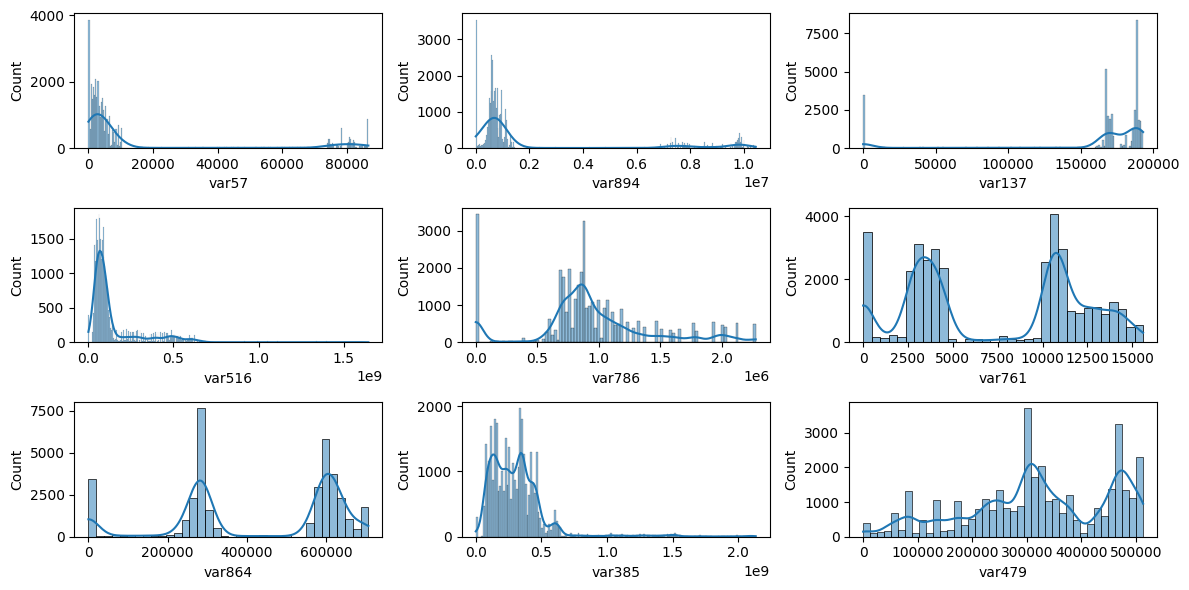

In [5]:
fig, ax = plt.subplots(3,3, figsize=(12,6))
posicao = [(i,j) for i in range(3) for j in range(3)]
for m in posicao:
    sns.histplot(x=data_train.iloc[:,randint(0,1000)], kde=True, ax=ax[m])
fig.tight_layout()

# Data Preparation

In [6]:
data_train.isna().sum().sort_values(ascending=False)

var586     18418
var584     18418
var576     18418
var577     18418
var578     18418
           ...  
var517      2793
var516      2793
var515      2793
var1000        0
alvo           0
Length: 1001, dtype: int64

In [3]:
data_train_wtomiss = data_train.copy()
data_train_wtomiss.fillna(0,inplace=True)

        O exercício pedia para realizar o deploy com apenas 100 campos, foi realizado um tratamento pelo método Anova que traz o nível de afinidade dos campos com o campo alvo.

        Bibliograficamente, o método identifica relações de maior afinidade a partir de P value menor que 0.005. Contudo, esse valor de afinidade não foi suficiente para identificar somente 100 campos. 

        Portanto, pelo método de tentativa e erro foi identificado e a afinidade deveria ser menor que 0.0000019 para os valores de P value, intensificando assim, a relação campo e alvo.
        
        Adicionalmente, o critério de avaliação levou em conta valores faltantes como zero, para que outros campos não perdessem a quantidade de informação mais de 50% dos dados que seriam desconsiderados em um drop. Além disso, os dados não foram tratados devido a quantidade de variáveis que problema contém, isso demandaria muito tempo e 90% dos campos serão desconsiderados.

In [4]:
anova = SelectKBest(score_func=f_regression, k=30)
anova.fit_transform(data_train_wtomiss.iloc[:,:1000],data_train_wtomiss['alvo'])

anova_num = pd.DataFrame( {'P_value_anova': anova.pvalues_},
                           index=data_train_wtomiss.columns.drop('alvo').to_list())

In [5]:
anova_cols = anova_num[anova_num.P_value_anova <= 0.0000019].index.to_list()  
print(len(anova_cols))

100


In [6]:
data_train[anova_cols].isnull().sum().sort_values(ascending=False)

var100    3363
var745    3363
var737    3363
var736    3363
var735    3363
          ... 
var411    3363
var408    3363
var858    3363
var532    2793
var531    2793
Length: 100, dtype: int64

In [6]:
data_cols_train = data_train[anova_cols].copy()
data_cols_test = data_test[anova_cols].copy()

        Apesar de existir métodos mais precisos para a imputação e previsão de dados faltantes, foi escolhido o método de imputação, pois era conveniente a relação custo-benefício, e tratamentos menos precisos, como média, podem levar tendências displiscentes aos dados, mesmo que agora há apenas aproximadamente 30% seria perdido dos dados.

        O método foi aliado ao Standard Scaler porque diminui a imprecisão da interpolação, e pode distribuir os dados de acordo com a distância euclidiana de cada ponto nas vizinhanças. E pode-se também, definir a quantidade de vizinhanças no método, como neste caso, o alvo é uma variável binomial duas vizinhanças deve encontrar a diferença suficiente entre casos críticos e não críticos.

In [53]:
standard = StandardScaler()
data_train_scaled = standard.fit_transform(data_cols_train)
data_test_scaled = standard.transform(data_cols_test)

In [54]:
imputer = KNNImputer(n_neighbors=2, weights='distance')
data_train_miss = imputer.fit_transform(data_train_scaled)

In [55]:
data_test_miss = imputer.transform(data_test_scaled)

In [56]:
data_train_transform = pd.DataFrame(data_train_miss, columns=data_cols_train.columns)
data_test_transform = pd.DataFrame(data_test_miss, columns=data_cols_test.columns)

data_train_transform['alvo'] = data_train['alvo']
data_test_transform['alvo'] = data_test['alvo']

# Modeling

        Para efeito de comparação foram deixados dois métodos, porém houveram diversos outros testes com outros métodos e alguns formatos de dados.

In [95]:
def model(algorthim ,*args, **kwargs):
    model = algorthim(*args, **kwargs)
    model.fit(data_train_transform.drop('alvo', axis=1), data_train_transform['alvo'])

    prob_val = model.predict_proba(data_test_transform.drop('alvo', axis=1))
    prob_val = prob_val[:, 1]

    predict= model.predict(data_test_transform.drop('alvo', axis=1))
    return prob_val, predict

In [96]:
prob_lgr, predict_lgr = model(LogisticRegression,solver='newton-cholesky')

In [97]:
prob_dtc,predict_dtc = model(DecisionTreeClassifier)

# Evaluation

        Foram criados métodos para facilitar a etapa de testes e melhoria dos modelos.

In [65]:
linha = [0 for _ in range(len(data_test['alvo']))]
def area_roc(y_pred, metodo: str):
    lr_auc = roc_auc_score(data_test_transform['alvo'], y_pred)

    ns_fpr, ns_tpr, _ = roc_curve(data_test_transform['alvo'], linha)
    lr_fpr, lr_tpr, _ = roc_curve(data_test_transform['alvo'], y_pred)

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sem treinar')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Regressão Logística')
    plt.title(f'{metodo}: ROC AUC=%.3f' % (lr_auc))

    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.legend()
    plt.show()

def confusion_matrix_(y_pred):
    cm = confusion_matrix(data_test_transform['alvo'], y_pred)
    cm_display = ConfusionMatrixDisplay(cm)
    cm_display.plot(cmap='Blues')

        Pode-se observar abaixo que a probabilidade de acerto de pessoas em estado não crítico pela Regressão logísitica é razoavelmente boa. Contudo, ela prevê todos como não-críticos causando uma impressão de que somente prevê todo dado como valor 0, o que é ruim.

        Quando se observa a Árvore de decisão, temos um um erro considerável que apresenta uma 'melhor' distribuição da previsão, mas probabilidade de acerto decai um pouco. 

        Apesar da melhor qualidade de probalidade dos dados na Regressão Logísitica, a Árvore de decisões além de encontra padrões para definir quais são os casos críticos e não-críticos, também encontra uma relação que permeia, ao menos pouco, a previsão de casos críticos.
        
        Por isso considero a melhor opção a Árvore de Decisões.

        Por fim, uma boa implementação seria realizar dois testes para prever com confiabilidade um para o caso não-crítico (este machine learning que está sendo apresentado) e um outro com dados com viés de casos críticos. Uma outra possibilidade, é implementar uma rede neural capaz de identificar com maior precisão ambos os casos de uma única vez. 

        É importante a aplicação do método obtido para que, caso o médico identifique um comportamento suspeito, e queira uma opinião que possa enxergar algo mais geral, o método aumentaria a confiança do médico na determinação do diagnóstico. Ou seja, aumentaria a eficiência do médico nas hipóteses de diagnóstico, diminuiria o receio do paciente no erro clínico e reduziria os riscos, dependendo da calamidade pública que está sendo discutida, tanto para o paciente, que poderá ter uma resposta mais rápida e precisa do seu caso, quanto do médico ao analisar o paciente com algumas perguntas.
        

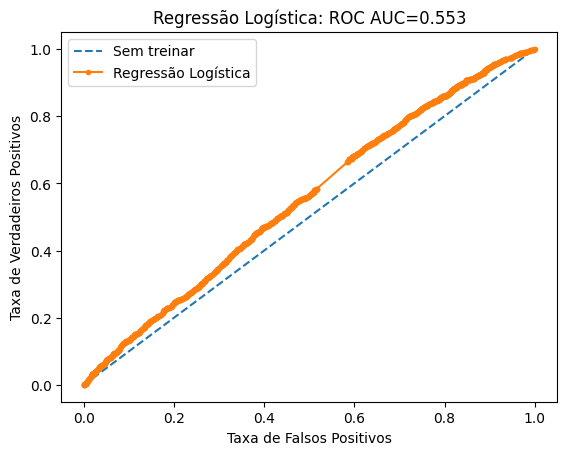

In [98]:
area_roc(prob_lgr, 'Regressão Logística')

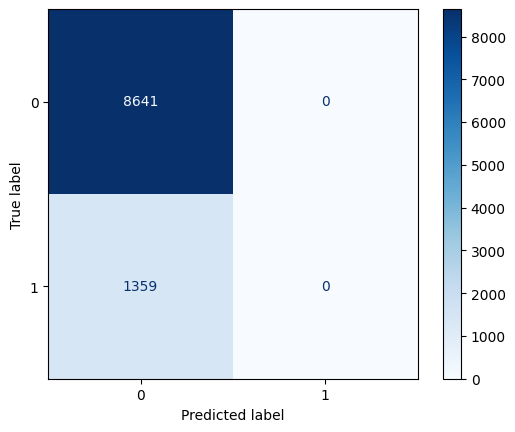

In [59]:
confusion_matrix_(predict_lgr)

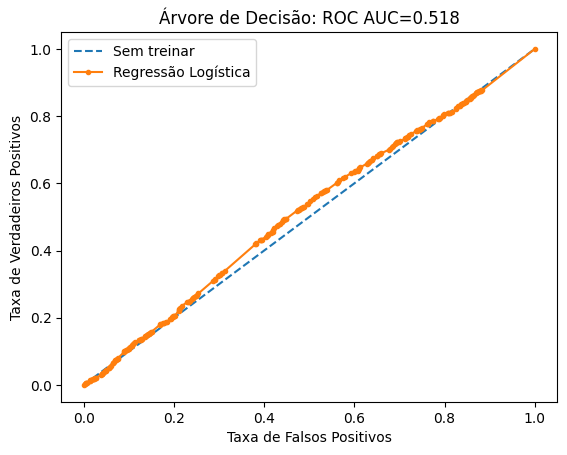

In [67]:
area_roc(prob_dtc, 'Árvore de Decisão')

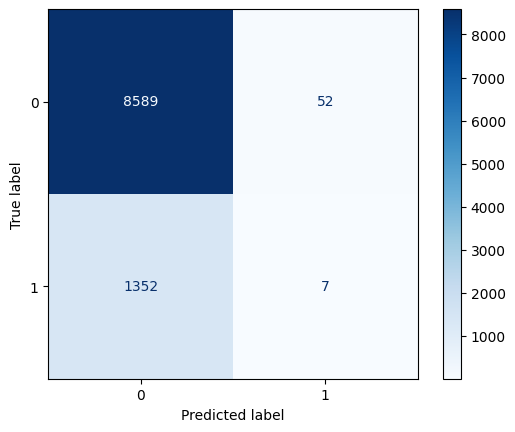

In [62]:
confusion_matrix_(predict_dtc)